## Practical Machine Learning

In [147]:
%matplotlib inline
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, adjusted_rand_score,homogeneity_score, completeness_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import csv
import matplotlib.pyplot as cm
import numpy as np
import pandas as pd
import pylab
import seaborn as sns; 
import string

In [161]:
dataset = pd.read_json(r"C:\Users\Asus\Desktop\pml\Sarcasm_Headlines_Dataset.json", lines=True)
dataset = dataset.drop(columns=['article_link'], axis=1)
dataset.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [68]:
dataset.shape

(26709, 2)

In [69]:
dataset.columns.values

array(['headline', 'is_sarcastic'], dtype=object)

Pre-processing: remove punctuation and apply stemming

In [70]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import WhitespaceTokenizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.corpus import stopwords
stops = set(stopwords.words("english")) 
englishStemmer=SnowballStemmer("english") #define stemming dict
#remove punctuation
dataset['headline'] = dataset['headline'].str.replace('[^\w\s]','')
#define stemming function
w_tokenizer = WhitespaceTokenizer()
def stemm_texts(text):
    return [englishStemmer.stem(w) for w in w_tokenizer.tokenize(str(text))]
#remove stop-words
def remove_stops(row):
    my_list = row['headline']
    meaningful_words = [w for w in my_list if not w in stops]
    return (meaningful_words)
dataset = dataset.apply(lambda y: y.map(stemm_texts, na_action='ignore'))
dataset['headline'] = dataset.apply(remove_stops, axis=1)
#detokenize words
detokenizer = TreebankWordDetokenizer()
dataset = dataset.apply(lambda y: y.map(detokenizer.detokenize, na_action='ignore'))
dataset.head()

,headline,is_sarcastic
0,former versac store clerk sue secret black cod...,0
1,roseann reviv catch thorni polit mood better wors,0
2,mom start fear son web seri closest thing gran...,1
3,boehner want wife listen come altern debtreduc...,1
4,jk rowl wish snape happi birthday magic way,0


## K-Means Clustering

In [162]:
tfidf = TfidfVectorizer(
    min_df = 5,
    max_df = 0.95,
    max_features = 8000,
    stop_words = 'english'
)
tfidf.fit(dataset['headline'])
text = tfidf.transform(dataset['headline'])

In [102]:
#clusters = MiniBatchKMeans(n_clusters=2, init_size=1024, batch_size=2048, random_state=20).fit_predict(text)
km = KMeans(n_clusters=2, init='k-means++')
%time km.fit(text)

Wall time: 23.1 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

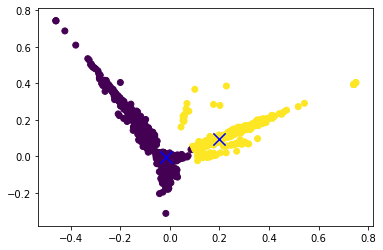

In [105]:
from sklearn.decomposition import PCA
# reduce the features to 2D
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(text.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(km.cluster_centers_)
plt.scatter(reduced_features[:,0], reduced_features[:,1], c=km.predict(text))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [163]:
labels = list(dataset['is_sarcastic'])
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.predict(text)))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.predict(text)))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.predict(text)))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels, km.predict(text)))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels, km.predict(text)))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(text, labels))

Homogeneity: 0.020
Completeness: 0.059
V-measure: 0.030
Adjusted Rand Index: -0.011
Adjusted Mutual Information: 0.020


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


Silhouette Coefficient: 0.001


## DBSCAN Clustering

In [155]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.datasets import make_blobs

In [171]:
labels_true = labels
text = StandardScaler(with_mean=False).fit_transform(text)
db = DBSCAN(eps=0.95, min_samples=100).fit(text)
core_samples = db.core_sample_indices_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = 2
n_noise_ = list(labels).count(-1)

print('Number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(text, labels))


Number of clusters: 2
Estimated number of noise points: 26709
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000


C:\Users\Asus\Anaconda3\lib\site-packages\sklearn\metrics\cluster\supervised.py:746: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [169]:
import pylab as pl
from itertools import cycle
pl.close('all')
pl.figure(1)
pl.clf()
colors = cycle('bgrcmybgrcmybgrcmybgrcmy')
for k, col in zip(set(labels), colors):
    if k == -1:
        # Black used for noise.
        col = 'k'
        markersize = 2
    class_members = [index[0] for index in np.argwhere(labels == k)]
    cluster_core_samples = [index for index in core_samples
                            if labels[index] == k]
    for index in class_members:
        x = text[index]
        if index in core_samples and k != -1:
            markersize = 14
        else:
            markersize = 6
        pl.plot(x[0], x[1], 'o', markerfacecolor=col,
                markeredgecolor='k', markersize=markersize)
pl.show()

IndexError: row index (1) out of range

<Figure size 432x288 with 0 Axes>

## Supervised test

In [62]:
features = dataset['headline']
labels = dataset['is_sarcastic']

In [63]:
# vectorizing the data with maximum of 5000 features
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [9]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .05, random_state = 0)

In [11]:
from sklearn.svm import LinearSVC
# model 1:-
# Using linear support vector classifier
lsvc = LinearSVC()
# training the model
lsvc.fit(features_train, labels_train)
# getting the score of train and test data
print(lsvc.score(features_train, labels_train)) # 90.93
print(lsvc.score(features_test, labels_test))   # 83.75

0.908012454183581
0.8330838323353293
